# LoL Win-Loss Prediction Model

**Name(s)**: Minchan Kim, David Moon

**Website Link**: https://m1nce.github.io/wrmodel/

## Code

In [126]:
import pandas as pd
import numpy as np
import os
import pathlib
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, Binarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
pd.options.plotting.backend = 'plotly'

In [127]:
data_path = Path('data') / '2022_LoL_esports_match_data_from_OraclesElixir.csv'
df = pd.read_csv(data_path,low_memory=False)
df.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,121.0,391.0,345.0,14.0,0.0,1.0,0.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,100.0,541.0,-275.0,-11.0,2.0,3.0,2.0,0.0,5.0,1.0
2,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,119.0,-475.0,153.0,1.0,0.0,3.0,0.0,3.0,3.0,2.0
3,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,149.0,-793.0,-1343.0,-34.0,2.0,1.0,2.0,3.0,3.0,0.0
4,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,21.0,443.0,-497.0,7.0,1.0,2.0,2.0,0.0,6.0,2.0


### Framing the Problem

For our analysis, we decided to predict whether or not a team will win or lose. We decided to use a binary classification because a game only has two outcomes, a win or a loss. Because this is the way games are set up, we will consider a win to be the number "1" and a loss to be the number "0".

In [128]:
is_lck = 'LCK'
default = df.loc[:, ['gameid', 'league','position','side', 'result', 'golddiffat10','firstherald','firstdragon','firstblood','xpdiffat10','csdiffat10']]
default = default[default['position'] == 'team']
#gets rid of games that have no result
groupbyresult = default.groupby(['gameid'])[['result']].sum()
remove_games = groupbyresult[groupbyresult['result'] != 6].index
default = default[default.isin(remove_games).any(axis=1)]
default = default[default['league'] == is_lck]
default

,gameid,league,position,side,result,golddiffat10,firstherald,firstdragon,firstblood,xpdiffat10,csdiffat10
1450,ESPORTSTMNT01_2700815,LCK,team,Blue,0,281.0,1.0,0.0,1.0,404.0,6.0
1451,ESPORTSTMNT01_2700815,LCK,team,Red,1,-281.0,0.0,1.0,0.0,-404.0,-6.0
1462,ESPORTSTMNT01_2690695,LCK,team,Blue,0,-1200.0,1.0,0.0,0.0,-1277.0,-15.0
1463,ESPORTSTMNT01_2690695,LCK,team,Red,1,1200.0,0.0,1.0,1.0,1277.0,15.0
1486,ESPORTSTMNT01_2690705,LCK,team,Blue,1,152.0,1.0,1.0,1.0,-948.0,-13.0
...,...,...,...,...,...,...,...,...,...,...,...
129503,ESPORTSTMNT04_2451974,LCK,team,Red,1,578.0,0.0,1.0,0.0,757.0,29.0
129538,ESPORTSTMNT04_2472110,LCK,team,Blue,0,-2261.0,0.0,0.0,0.0,-1791.0,6.0
129539,ESPORTSTMNT04_2472110,LCK,team,Red,1,2261.0,1.0,1.0,1.0,1791.0,-6.0
129562,ESPORTSTMNT04_2472111,LCK,team,Blue,1,308.0,0.0,1.0,0.0,956.0,20.0


### Baseline Model

For our baseline model, we wanted to predict a team's outcome (win or loss) depending on a couple of features. We used the `side`, `golddiffat10`, `firstherald`, `firstdragon`, `firstblood`, `xpdiffat10`, and `csdiffat10` columns in order to predict the outcome.

In [129]:
X = default.drop(columns=['gameid','league','position','result'])
y = default['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [130]:
preproc = ColumnTransformer(
    transformers=[
        ('categorical_col', OneHotEncoder(), ['side'])
    ],
    remainder='passthrough'
)

In [131]:
pl = Pipeline([
    ('preprocessor', preproc),
    ('clf', DecisionTreeClassifier(max_depth=3)) 
])

In [132]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_col',
                                                  OneHotEncoder(),
                                                  ['side'])])),
                ('clf', DecisionTreeClassifier(max_depth=3))])

In [133]:
pl.score(X_train, y_train)

0.7001338688085676

In [134]:
pl.score(X_test, y_test)

0.6631016042780749

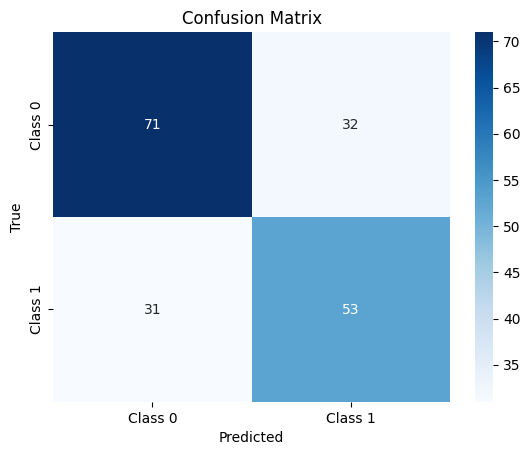

In [135]:
conf_matrix = confusion_matrix(y_test, pl.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Final Model

In [136]:
final_df = df[(df['position'] == 'team') & (df['league'] == 'LCK')]
final_df = final_df[['result', 'team kpm', 'barons', 'firsttothreetowers', 'dpm', 'earned gpm', 'inhibitors', 'elders', 'dragons', 'towers']]
final_df.head()

,result,team kpm,barons,firsttothreetowers,dpm,earned gpm,inhibitors,elders,dragons,towers
1450,0,0.1367,0.0,1.0,1367.7813,1092.7927,0.0,0.0,1.0,8.0
1451,1,0.3827,2.0,0.0,1614.6970,1200.0000,2.0,0.0,4.0,9.0
1462,0,0.2029,1.0,0.0,1935.4783,1106.7246,0.0,0.0,0.0,3.0
1463,1,0.4348,1.0,1.0,1670.0290,1294.4928,1.0,0.0,4.0,9.0
1486,1,0.3224,1.0,1.0,1997.1429,1136.6950,1.0,1.0,5.0,7.0


In [137]:
X = final_df.drop(columns='result')
y = final_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [138]:
preproc = ColumnTransformer(
    transformers=[
        ('5towers', Binarizer(threshold=4), ['towers']),
        ('stdscaler', StandardScaler(), ['team kpm', 'dpm', 'earned gpm'])
    ],
    remainder='passthrough' # Specify what to do with all other columns ('total_bill' here) – drop or passthrough.
)

In [139]:
pl = Pipeline([
    ('preprocessor', preproc),
    ('clf', DecisionTreeClassifier(max_depth=3))
])

In [140]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('5towers',
                                                  Binarizer(threshold=4),
                                                  ['towers']),
                                                 ('stdscaler', StandardScaler(),
                                                  ['team kpm', 'dpm',
                                                   'earned gpm'])])),
                ('clf', DecisionTreeClassifier(max_depth=3))])

In [141]:
pl.score(X_train, y_train)

0.9692101740294511

In [142]:
pl.score(X_test, y_test)

0.9625668449197861

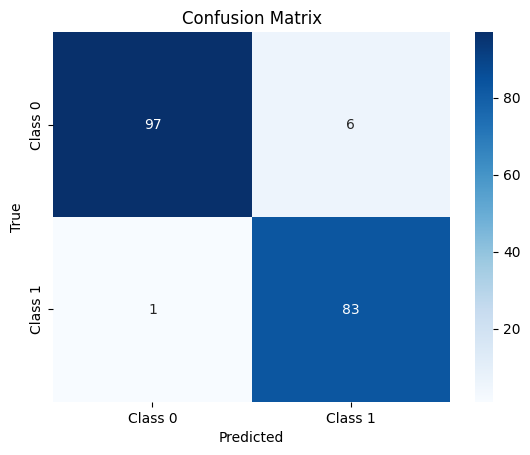

In [143]:
conf_matrix = confusion_matrix(y_test, pl.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [144]:
param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
    # Add other hyperparameters you want to tune
}

In [145]:
grid_search = GridSearchCV(pl, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('5towers',
                                                                         Binarizer(threshold=4),
                                                                         ['towers']),
                                                                        ('stdscaler',
                                                                         StandardScaler(),
                                                                         ['team '
                                                                          'kpm',
                                                                          'dpm',
                                                                          'earned '
                                                                      

In [146]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [147]:
best_model.score(X_train, y_train)

0.9906291834002677

In [148]:
best_model.score(X_test, y_test)

0.946524064171123

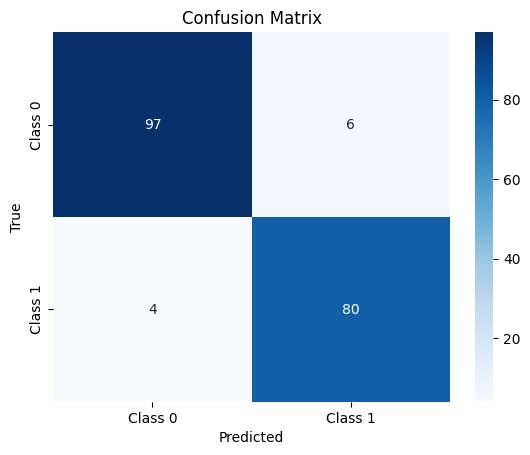

In [149]:
conf_matrix = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Fairness Analysis

In [150]:
# TODO